### Import data

In [1]:
setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/")
data <- read.csv("features_data.csv")
setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/feature-selection/")

In [2]:
head(data)
str(data)

Animal,Corte,Grupo,Region,Foreground.pixels.by.hull.area,Hull.Area,Diameter.of.Bounding.Circle,Mean.Radius,Cell.Area,Cell.Perimeter,...,Hull.void.area,Branches,Junctions,End.point.voxels,Triple.points,Quadruple.points,Average.branch.length,Maximum.branch.length,D,Lacunarity
CS2,1,CS,CA1,0.5968,2282,74.9667,31.5814,1362,344.416,...,920,15,7,9,7,0,13.283,29.556,1140,801
CS2,1,CS,CA1,0.8191,376,32.8571,14.7844,308,91.983,...,68,3,1,3,1,0,13.876,22.142,41,1246
CS2,1,CS,CA1,0.4057,2036,78.4092,32.8051,826,246.635,...,1210,7,3,5,3,0,17.840,34.627,87,1271
CS2,1,CS,CA1,0.4576,2380,69.3097,30.9999,1089,341.061,...,1291,20,11,7,11,0,10.674,27.385,429,1659
CS2,1,CS,CA1,0.4241,2457,70.9627,32.7330,1042,371.588,...,1415,18,9,9,9,0,12.222,20.071,585,1452
CS2,1,CS,CA1,0.2993,5362,119.4364,50.7948,1605,709.720,...,3757,40,19,20,17,1,10.588,31.799,538,1596


'data.frame':	2160 obs. of  23 variables:
 $ Animal                        : Factor w/ 12 levels "AL1","AL2","AL3",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ Corte                         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Grupo                         : Factor w/ 3 levels "AL","AS","CS": 3 3 3 3 3 3 3 3 3 3 ...
 $ Region                        : Factor w/ 3 levels "CA1","CA3","GD": 1 1 1 1 1 1 1 1 1 1 ...
 $ Foreground.pixels.by.hull.area: num  0.597 0.819 0.406 0.458 0.424 ...
 $ Hull.Area                     : int  2282 376 2036 2380 2457 5362 810 1529 567 2735 ...
 $ Diameter.of.Bounding.Circle   : num  75 32.9 78.4 69.3 71 ...
 $ Mean.Radius                   : num  31.6 14.8 32.8 31 32.7 ...
 $ Cell.Area                     : int  1362 308 826 1089 1042 1605 297 863 442 1618 ...
 $ Cell.Perimeter                : num  344 92 247 341 372 ...
 $ Solidity                      : num  0.57 0.715 0.383 0.435 0.403 0.289 0.336 0.53 0.703 0.566 ...
 $ Round                         : num  0.494 0.564 

### Build Functions

**description**

In [89]:
library("cluster")
library("factoextra")
source("./_h/ggbiplot.R")

# checking sill for a parameters data.frame (data = raw, parameters = list of parameters)
val.sill <- function(data,parameters, show.plot = FALSE, componentes = 1:2){
  output <- list()
  #erro
  if(max(componentes) > ncol(parameters)){return(cat("Numero de componentes
                                                     incompativel com o numero
                                                     de parametros!\n"))}
  
  if(is.data.frame(parameters)){
    for(i in 1:nrow(parameters)){
      par   <- unlist(parameters[i,], use.names = FALSE)
      pca   <- prcomp(data[par], center = TRUE, scale = TRUE)
      
      coord <- pca$x[,componentes]
      dista <- dist(coord,method = "euclidian")
      clust <- hclust(dista, method = "ward.D2")
    
      id.k3 <- as.factor(cutree(clust,k=3))
      id.k2 <- as.factor(cutree(clust,k=2))
    
      #k = 3
      sill.k3 <- silhouette(cutree(clust, k= 3), dista)
      sill.df <- as.tibble(sill.k3[,1:3])
      
      sill.mean <- sill.df %>% 
        group_by(cluster) %>% dplyr::summarise(silhoutte.mean = mean(sil_width))
      
      nª.negative = c(length(which(sill.df$sil_width < 0 & sill.df$cluster == 1)),
                      length(which(sill.df$sil_width < 0 & sill.df$cluster == 2)),
                      length(which(sill.df$sil_width < 0 & sill.df$cluster == 3)))
      #sill.info <- cbind(sill.mean,nª.negative)
      negative.percent <- sum(nª.negative/nrow(sill.df))
      
      k3.info <- list(negative.percent = negative.percent, mean.all = mean(sill.mean$silhoutte.mean), mean.cluster = sill.mean$silhoutte.mean)
           
      #k = 2              
      sill.k2 <- silhouette(cutree(clust, k= 2), dista)
      sill.df <- as.tibble(sill.k2[,1:3])
      
      sill.mean <- sill.df %>% 
        group_by(cluster) %>% dplyr::summarise(silhoutte.mean = mean(sil_width))
      
      nª.negative = c(length(which(sill.df$sil_width < 0 & sill.df$cluster == 1)),
                      length(which(sill.df$sil_width < 0 & sill.df$cluster == 2)))
        
      #sill.info <- cbind(sill.mean,nª.negative)
        
      negative.percent <- sum(nª.negative/nrow(sill.df))
      
      k2.info <- list(negative.percent = negative.percent, mean.all = mean(sill.mean$silhoutte.mean), mean.cluster = sill.mean$silhoutte.mean)
      
      if(show.plot){
      p.k3 <- ggbiplot(pca, choices = 1:2, alpha = 0.1, ellipse = TRUE, 
              groups = id.k3) + scale_color_manual(name="Cluster", 
              values=c("#0072B2","#CC6666","#66CC99")) +
              theme(legend.direction ="horizontal", legend.position = "top")
      p.k2 <- ggbiplot(pca, choices = 1:2, alpha = 0.1, ellipse = TRUE, 
              groups = id.k2) + scale_color_manual(name="Cluster", 
              values=c("#0072B2","#CC6666","#66CC99")) +
              theme(legend.direction ="horizontal", legend.position = "top")
     
      p.s3 <- fviz_silhouette(silhouette(cutree(clust, k= 3),dista),
              palette = c("#0072B2","#CC6666","#66CC99"))+
              theme(plot.title = element_text(hjust = 0.5))
      p.s2 <- fviz_silhouette(silhouette(cutree(clust, k= 2),dista),
              palette = c("#0072B2","#CC6666","#66CC99"))+
              theme(plot.title = element_text(hjust = 0.5))
      p <- list(p.k3,p.s3,p.k2,p.s2)
      
      output[[i]] <- list(plots = p, k2 = k2.info, k3 = k3.info)
      }
      else{
      output[[i]] <- list(k2 = k2.info, k3 = k3.info)
      }
    }
    
  } else(cat("Parameters structure invalid: data.frame only\n"))

return(output)
}

**description**

In [4]:
# check for the higher silhoutte mean
max.sill <- function(sill.validation, plot = TRUE){
  # mean sill results in a vector
  k2 <- vector(mode = "numeric", length = length(sill.validation))
  k3 <- vector(mode = "numeric", length = length(sill.validation))
  for(i in 1:length(k2)){k2[i] <- sill.validation[[i]]$k2$mean.all}
  for(i in 1:length(k3)){k3[i] <- sill.validation[[i]]$k3$mean.all}
  
  if(plot){
    #k = 2
    k2.ps   <- sill.validation[[which(k2 == max(k2))]]$plot[4]
    k2.pc   <- sill.validation[[which(k2 == max(k2))]]$plot[3]
    k2.info <- sill.validation[[which(k2 == max(k2))]]$k2
    #k = 3
    k3.ps   <- sill.validation[[which(k3 == max(k3))]]$plot[2]
    k3.pc   <- sill.validation[[which(k3 == max(k3))]]$plot[1]
    k3.info <- sill.validation[[which(k3 == max(k3))]]$k3
    
    
    plot    <- list(k2 = list(k2.ps,k2.pc),k3 = list(k3.ps,k3.pc))
    info    <- list(k2 = k2.info, k3 = k3.info)
    id      <- list(k2 = which(k2 == max(k2)),k3 = which(k3 == max(k3)) )
    outcome <- list(plot = plot, info = info, id = id)
  }
  else{
    k2.info <- sill.validation[[which(k2 == max(k2))]]$k2
    k3.info <- sill.validation[[which(k3 == max(k3))]]$k3
    info    <- list(k2 = k2.info, k3 = k3.info)
    id      <- list(k2 = which(k2 == max(k2)),k3 = which(k3 == max(k3)) )
    outcome <- list(info = info, id = id)
  }
  return(outcome)
}


**description**

In [5]:
# evaluate proportion of variance (pov) by group of parameters
pov.threshold <- function(data,parameters,threshold){
output <- list()
c  <- 0 
    
for(i in 1:nrow(parameters)){    
    par <- unlist(parameters[i,], use.names = FALSE)
    pca <- prcomp(data[par], center = TRUE, scale = TRUE)
    pov <- sum(summary(pca)$importance[2,1:2])  # summing pc1 and pc2 proportion of variance

    if (pov > threshold){
        c <- c + 1
        output[[c]] <- list(parameters = par, pov = pov)
    }
}
return(output)
}

**description**

In [6]:
# multiplot from cookbook-r
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

**description**

In [ ]:
# a little function to build tables for sill and pca description
table.sill.info <- function(sill.evaluation, pov, k, i){
    if(k == 3){
        table <- tibble(negative_sill_percent = round(sill.evaluation[[i]]$k3$negative.percent, digits = 3),
                        pov = round(pov[[i]]$pov, digits = 3),
                        sill_cluster_1 = round(sill.evaluation[[i]]$k3$mean.cluster[1], digits = 3),
                        sill.cluster_2 = round(sill.evaluation[[i]]$k3$mean.cluster[2], digits = 3),
                        sill_cluster_3 = round(sill.evaluation[[i]]$k3$mean.cluster[3], digits = 3),
                 )
        return(table)
        }
    if(k == 2){
        table <- tibble(negative_sill_percent = round(sill.evaluation[[i]]$k2$negative.percent, digits = 3),
                        pov = round(pov[[i]]$pov, digits = 3),
                        sill_cluster_1 = round(sill.evaluation[[i]]$k2$mean.cluster[1], digits = 3),
                        sill.cluster_2 = round(sill.evaluation[[i]]$k2$mean.cluster[2], digits = 3)
                        )
        return(table)
        }
    else{print("input error")}
}

### Correlation Plot

corrplot 0.90 loaded
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ───────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.7
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.4     ✔ forcats 0.4.0
── Conflicts ──────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


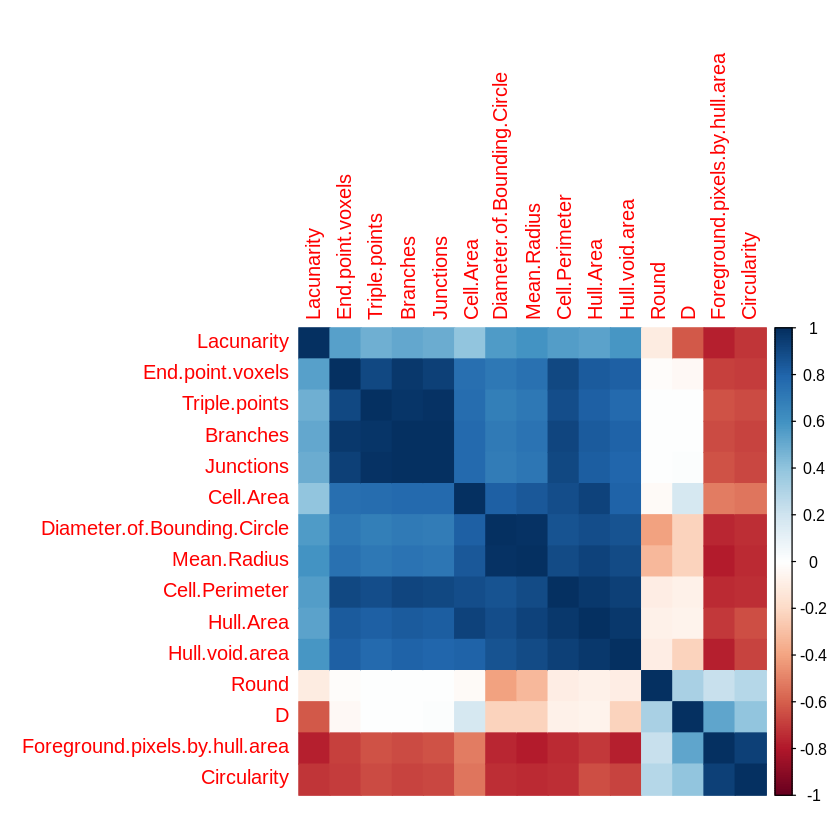

In [7]:
library("corrplot")
library("tidyverse")

data.cor <- data %>% select(-Quadruple.points,-Average.branch.length,-Maximum.branch.length, -Solidity)


corrplot(cor(data.cor[,5:19]), method = "color", order = "hclust")

rm(data.cor)

Description and criating groups

### PCA & Silhuette

#### Crossing parameters

Crossing parameters to build groups of variables to test

In [8]:
# crossing() em vetores de parâmetros em categorias pre arranjadas

# essenciais
negative.cor      <- c("Circularity","Foreground.pixels.by.hull.area") # correlação negativa
cell.domain       <- c("Diameter.of.Bounding.Circle",
                       "Mean.Radius","Hull.Area","Hull.void.area")                # Cell Size/Domain
cell.ramification <- c("Junctions","Triple.points","Branches","End.point.voxels") # Ramificação Skeleton

# adicionais 
extra.ramification <- c("Quadruple.points")            # ramificação
extra.size         <- c("Cell.Area","Cell.Perimeter")  # Cell Size
extra.porosity     <- c("Lacunarity")                  # porosidade
extra.uncor        <- c("Round","D")                   # não correlacionaveis 
 
#combinantions
# 3 combination
parameters.3 <- crossing(negative.cor,cell.domain,cell.ramification)

# 4 combinations
parameters.4.1 <- crossing(negative.cor,cell.domain,cell.ramification,extra.size) # + size
parameters.4.2 <- crossing(negative.cor,cell.domain,cell.ramification,extra.porosity) # + porosity
parameters.4.3 <- crossing(negative.cor,cell.domain,cell.ramification,extra.uncor) # + uncor

# 5 combinations
parameters.5.1 <- crossing(negative.cor,cell.domain,cell.ramification,extra.porosity, extra.size) # +p +s
parameters.5.2 <- crossing(negative.cor,cell.domain,cell.ramification,extra.porosity,extra.uncor) # +p +u
parameters.5.3 <- crossing(negative.cor,cell.domain,cell.ramification,extra.uncor, extra.size)    # +s +u

parameters.5.4 <- crossing(negative.cor,cell.domain,extra.ramification, extra.size) 

parameters.combination <- list(parameters.3,
                               parameters.4.1,
                               parameters.4.2,
                               parameters.4.3,
                               parameters.5.1,
                               parameters.5.2,
                               parameters.5.3,
                               parameters.5.4)

# cleaning variables
rm(parameters.4.1,parameters.4.2,parameters.4.3,parameters.5.1,parameters.5.2,parameters.5.3, parameters.5.4,parameters.3)
rm(negative.cor,cell.domain,cell.ramification,extra.porosity, extra.size,extra.uncor,extra.ramification)


#### Evaluate Proportion of Variance (POV) from PCA's

**Proportion of Variance > 80%**

In [9]:
for(i in 1:8){
    print(paste("Group of parameters",i))
    print(length(pov.threshold(data,parameters.combination[[i]],threshold = 0.80)))
}

[1] "Group of parameters 1"
[1] 32
[1] "Group of parameters 2"
[1] 64
[1] "Group of parameters 3"
[1] 32
[1] "Group of parameters 4"
[1] 64
[1] "Group of parameters 5"
[1] 64
[1] "Group of parameters 6"
[1] 64
[1] "Group of parameters 7"
[1] 128
[1] "Group of parameters 8"
[1] 16


**Proportion of Variance > 90%**

In [10]:
for(i in 1:8){
    print(paste("Group of parameters",i))
    print(length(pov.threshold(data,parameters.combination[[i]],threshold = 0.90)))
}

[1] "Group of parameters 1"
[1] 32
[1] "Group of parameters 2"
[1] 58
[1] "Group of parameters 3"
[1] 8
[1] "Group of parameters 4"
[1] 12
[1] "Group of parameters 5"
[1] 22
[1] "Group of parameters 6"
[1] 0
[1] "Group of parameters 7"
[1] 32
[1] "Group of parameters 8"
[1] 5


**Proportion of Variance > 95%**

In [25]:
for(i in 1:8){
    print(paste("Group of parameters",i))
    print(length(pov.threshold(data,parameters.combination[[i]],threshold = 0.95)))
}

pov <- pov.threshold(data,parameters.combination[[2]],threshold = 0.95)

[1] "Group of parameters 1"
[1] 0
[1] "Group of parameters 2"
[1] 7
[1] "Group of parameters 3"
[1] 0
[1] "Group of parameters 4"
[1] 0
[1] "Group of parameters 5"
[1] 0
[1] "Group of parameters 6"
[1] 0
[1] "Group of parameters 7"
[1] 0
[1] "Group of parameters 8"
[1] 0


#### Silhuette & Scatter Plot

Here we blablabla

> Negative Sill Percent:

> POV:

> Sill Cluster:


In [69]:
library("cluster")
library("knitr")
library("IRdisplay")

# selecting arrangements with pov > 95%
p <- parameters.combination[[2]][c(10,12,14,42,44,46,50),]

# silhuette test 
# invisible and capture.output were used to hide the output message
invisible(capture.output(sill.evaluation <- val.sill(data,p, show.plot = TRUE, componentes = 1:2)))

##### **Arrangement #01**
*Circularity, Hull Area, Branches and Cell Perimeter*

negative_sill_percent,pov,sill_cluster_1,sill.cluster_2,sill_cluster_3
0.043,0.953,0.35,0.535,0.507


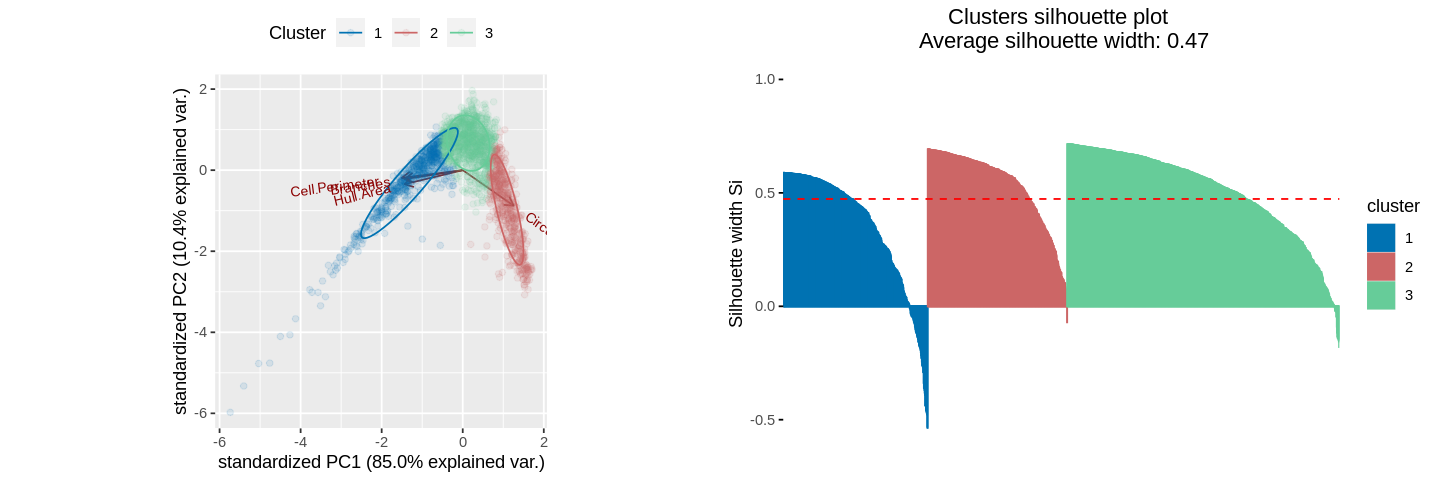

In [82]:
# k = 3
table.sill.info(sill.evaluation,pov, k = 3, i = 1)
multiplot(sill.evaluation[[1]]$plots[[1]],sill.evaluation[[1]]$plots[[2]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

negative_sill_percent,pov,sill_cluster_1,sill.cluster_2
0.033,0.953,0.491,0.537


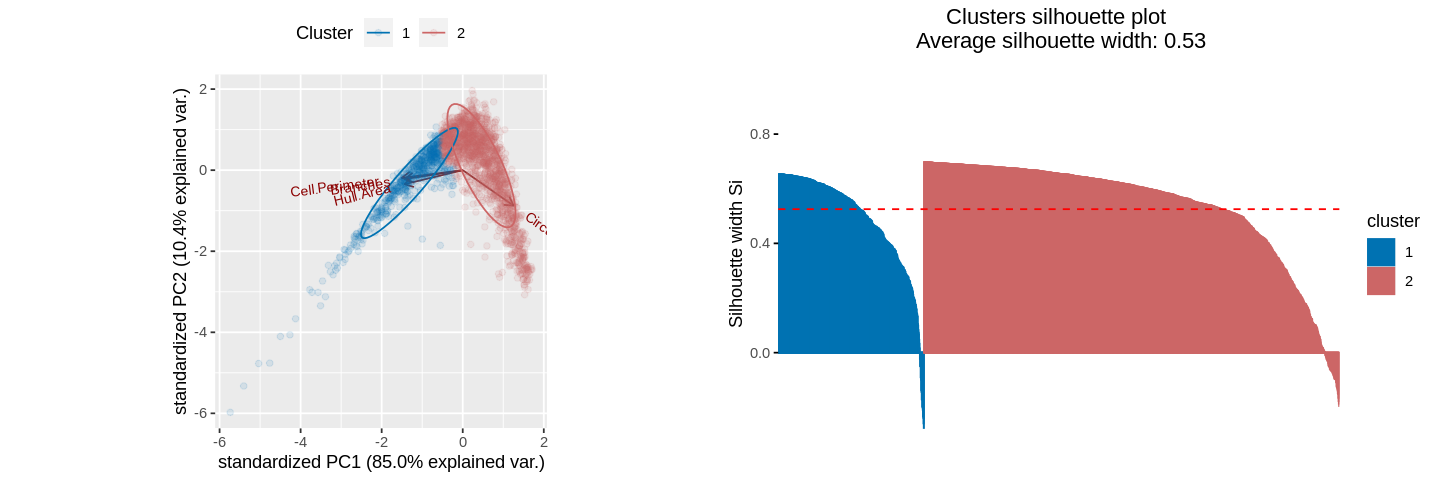

In [76]:
# k = 2
table.sill.info(sill.evaluation,pov, k = 2, i = 1)
multiplot(sill.evaluation[[1]]$plots[[3]],sill.evaluation[[1]]$plots[[4]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

##### **Arrangement #02**
*Circularity, Hull Area, End Point Voxels and Cell Perimeter*

negative_sill_percent,pov,sill_cluster_1,sill.cluster_2,sill_cluster_3
0.028,0.952,0.47,0.501,0.51


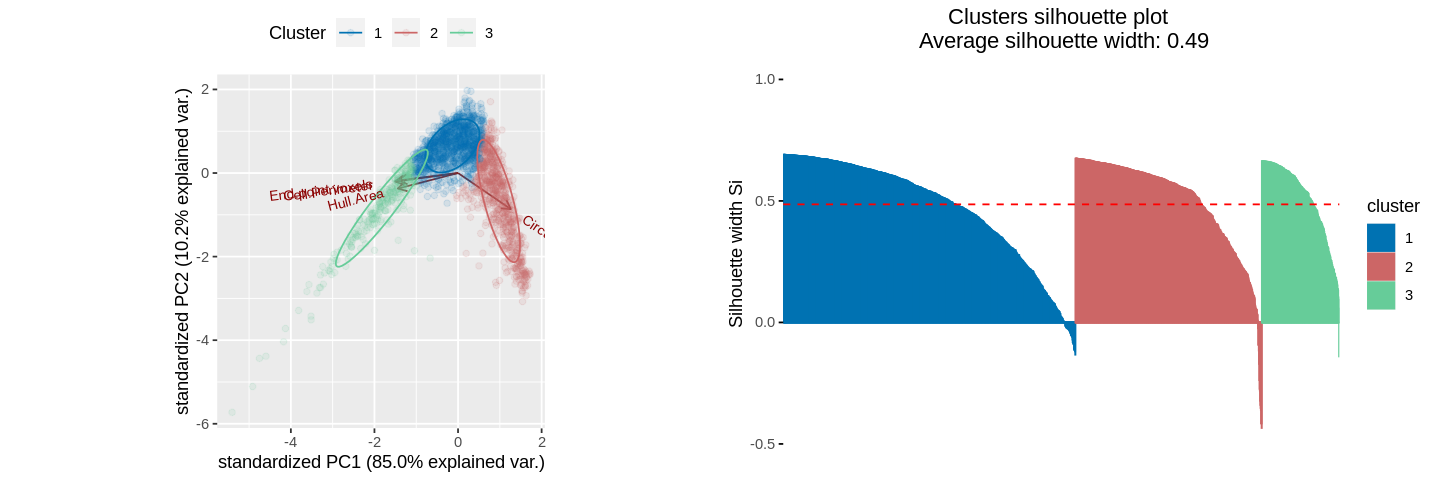

In [83]:
# k = 3
table.sill.info(sill.evaluation,pov, k = 3, i = 2)
multiplot(sill.evaluation[[2]]$plots[[1]],sill.evaluation[[2]]$plots[[2]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

negative_sill_percent,pov,sill_cluster_1,sill.cluster_2
0.05,0.952,0.547,0.618


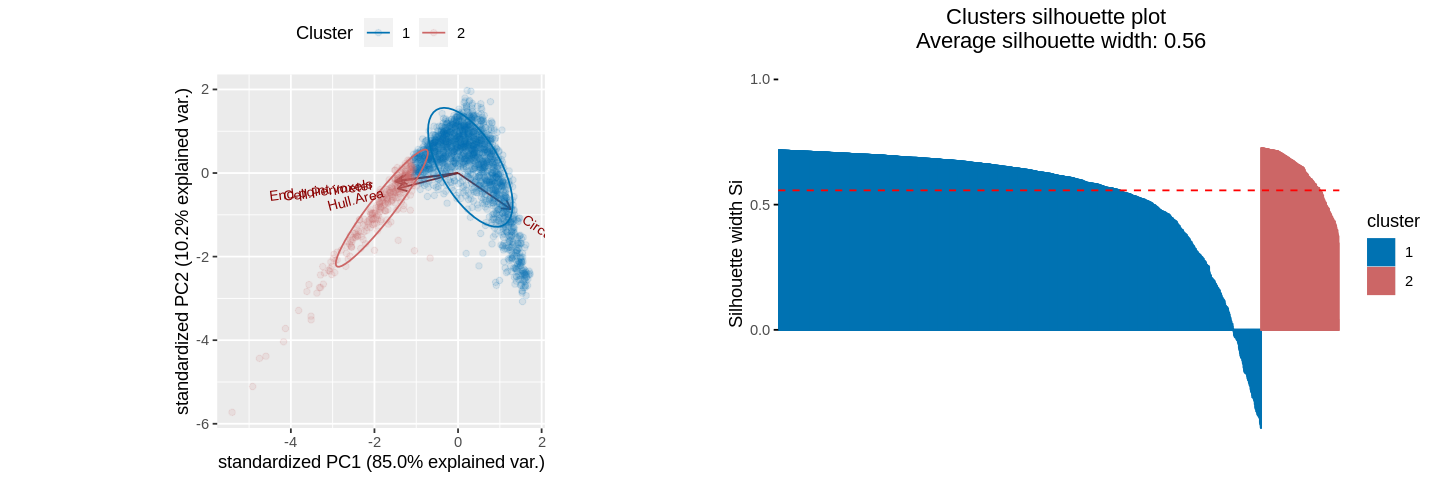

In [84]:
# k = 2
table.sill.info(sill.evaluation,pov, k = 2, i = 2)
multiplot(sill.evaluation[[2]]$plots[[3]],sill.evaluation[[2]]$plots[[4]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

##### **Arrangement #03**
*Circularity, Hull area, Junctions, Cell perimeter.*

In [ ]:
# k = 3
table.sill.info(sill.evaluation,pov, k = 3, i = 3)
multiplot(sill.evaluation[[3]]$plots[[1]],sill.evaluation[[3]]$plots[[2]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

In [ ]:
# k = 2
table.sill.info(sill.evaluation,pov, k = 2, i = 3)
multiplot(sill.evaluation[[3]]$plots[[3]],sill.evaluation[[3]]$plots[[4]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

##### **Arrangement #04**
*Foreground pixels by hull area (Solidity), Hull Area, Branches and Cell Perimeter.*

In [ ]:
# k = 3
table.sill.info(sill.evaluation,pov, k = 3, i = 4)
multiplot(sill.evaluation[[4]]$plots[[1]],sill.evaluation[[4]]$plots[[2]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

In [ ]:
# k = 2
table.sill.info(sill.evaluation,pov, k = 2, i = 4)
multiplot(sill.evaluation[[4]]$plots[[3]],sill.evaluation[[4]]$plots[[4]], cols = 2)
options(repr.plot.width=12, repr.plot.height=4)

##### **Arragement #05**

In [ ]:
pov[[5]]$parameters

In [ ]:
table.k3 <- tibble(parameters = c(pov[[1]]$parameters),
                   )

attributes(sill.evaluation[[1]])
sill.evaluation[[1]]$k3
pov[[1]]
c(pov[[1]]$parameters)

##### **Arragement #06**

In [ ]:
pov[[6]]$parameters

In [ ]:
table.k3 <- tibble(parameters = c(pov[[1]]$parameters),
                   )

attributes(sill.evaluation[[1]])
sill.evaluation[[1]]$k3
pov[[1]]
c(pov[[1]]$parameters)

##### **Arragement #07**

In [ ]:
pov[[7]]$parameters

In [ ]:
table.k3 <- tibble(parameters = c(pov[[1]]$parameters),
                   )

attributes(sill.evaluation[[1]])
sill.evaluation[[1]]$k3
pov[[1]]
c(pov[[1]]$parameters)

### Conclusion

**First** we classify the parameters in different categorys

**Second** we arranged diferent configurations 

**Third** we try to reduce the dimensions of the arrangements and evaluate the variance explained by PC1 and PC2. 
obs. we choose to do the Hierarquical Clustering in lower dimension (only in PC1 and PC2) as preliminar analysis showed better results.

**Fourth** we see the scatter plots from PCA and the silhuette plots from Hierarquical Clustering

As we wanted to work with a 3 phenotype classification, i.e. ameboid, partial and ramified, and we dont see relevant differences between k=2 and k=3 that could make us consider k = 2.


*show a box plot grouping by experimental group and verify the potential to explain the diferences saw in the grups analyzed by singled parameters* 

In [ ]:
p[1,]

In [ ]:
par   <- unlist(p[2,], use.names = FALSE)

pca   <- prcomp(data[par], center = TRUE, scale = TRUE)

coord <- pca$x[,1:2]
dista <- dist(coord,method = "euclidian")
clust <- hclust(dista, method = "ward.D2")

sill.k3 <- silhouette(cutree(clust, k= 3), dista)
sill.df <- as.tibble(sill.k3[,1:3])


In [ ]:
sill.mean <- sill.df %>% 
    group_by(cluster) %>% dplyr::summarise(silhoutte.mean = mean(sil_width))

mean(sill.mean$silhoutte.mean)